In [1]:
!pip install memory_profiler cv2 numpy matplotlib skimage

# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import skimage.color
import skimage.filters
import skimage.io
import skimage.feature
import skimage.measure
import skimage.color

from textureTransfer import Construct as transfer_texture
%matplotlib inline
%load_ext memory_profiler

# Utility functions

In [2]:
# Scaling or clipping
scale = lambda x, top=255: (top * (x - np.min(x))) / (np.max(x) - np.min(x))
inrange = lambda x: np.where(x > 255, 255, np.where(x < 0, 0, x))
invert = lambda x: np.max(x) - x
print_range = lambda x: print(np.min(x), np.max(x))

run_tests = False

# Image input and pre processing

In [3]:
def apply_filter(im, filt, zero_padding=False):
    
    wdth = filt.shape[0]//2
    
    filt_img = np.zeros(im.shape)
    
    if zero_padding:
        im = np.vstack( (np.zeros( (wdth, im.shape[1]) ), im, np.zeros( (wdth, im.shape[1]) ) ) )
        im = np.hstack( (np.zeros( (im.shape[0], wdth) ), im, np.zeros( (im.shape[0], wdth) ) ) )
    else:
        im = np.vstack(([im[0]]*wdth, im, [im[-1]]*wdth))
        im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*wdth)))

    for i in range(wdth, im.shape[0]-wdth):
        for j in range(wdth, im.shape[1]-wdth):
            filt_img[i-wdth][j-wdth] = np.sum(im[i-wdth:i+wdth+1, j-wdth:j+wdth+1] * filt)
    
    return np.rint(filt_img)

prewitt = [np.array(
               [[-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]]), 
           np.array(
               [[ 1,  1,  1],
                [ 0,  0,  0],
                [-1, -1, -1]])]


In [4]:
def decouple(img):
    
    img = img.astype('float64')
    
    with np.errstate(divide='ignore', invalid='ignore'):
        intensity_layer = np.nan_to_num(np.true_divide(((img[:, :, 0]**2) + (img[:, :, 1]**2) + (img[:, :, 2]**2)) , (img[:,:,0]+img[:, :, 1]+img[:, :, 2])))
        intensity_layer = np.rint(intensity_layer).astype('uint8')
        
        dx = apply_filter(intensity_layer, prewitt[0])
        dy = apply_filter(intensity_layer, prewitt[1])
        
        gradient = np.nan_to_num(np.arctan(dy/dx))
        
    return intensity_layer,gradient

# Distance function

In [5]:
def distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2

    tI = np.vstack(([tI[0]]*wdth_y, tI, [tI[-1]]*(Y-wdth_y)))
    tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x))))

    tG = np.vstack(([tG[0]]*wdth_y, tG, [tG[-1]]*(Y-wdth_y)))
    tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x))))
   
    g_img = np.zeros((M, N))
    l_img = np.zeros((M, N))
   
    for i in range(wdth_y, wdth_y+M):
        for j in range(wdth_x, wdth_x+N):
            try:
                g_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sG - tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
                l_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sI - tI[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
            
            except Exception:
                print("Source shape: ", sG.shape, "  i, j:", i, j, "   Patch shape:",  tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x].shape)
                raise Exception
            
    return (g_img / np.max(g_img)) + (l_img / np.max(l_img))

In [6]:
def inbuilt_distance(sI, sG, tI, tG, scalefactor=True):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2
    try:
        if wdth_y:
            tI = np.vstack(([tI[0]]*wdth_y, tI))
            tG = np.vstack(([tG[0]]*wdth_y, tG))
        if Y-wdth_y-1:
            tI = np.vstack((tI, [tI[-1]]*(Y-wdth_y-1)))
            tG = np.vstack((tG, [tG[-1]]*(Y-wdth_y-1)))
        
        if wdth_x:
            tI = np.hstack((np.hstack([ tI[:,0].reshape(-1,1)]*wdth_x), tI))
            tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG))
        if X-wdth_x-1:
            tI = np.hstack((tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            tG = np.hstack((tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            
    except Exception:
        print("\n", wdth_x, wdth_y, Y-wdth_y-1, X-wdth_x-1)
        raise Exception   

#     lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF_NORMED)
#     grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF_NORMED)

    lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF)
    grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF)

    if scalefactor:
        return scale(invert(lum+grd), 1)
    
    return invert(lum+grd)

In [7]:
def median_filter(im, k):
        
    filt_img = np.zeros(im.shape)

    wdth = k//2

    im = np.vstack(([im[0]]*wdth, im, [im[-1]]*(k-wdth)))
    im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*(k-wdth))))

    for j in range(wdth, im.shape[1]-wdth):
        for i in range(wdth, im.shape[0]-wdth):
            x = np.median(im[i-wdth:i+k-wdth+1, j-wdth:j+k-wdth+1])
            filt_img[i-wdth][j-wdth] = x
    
    return filt_img

# Age Map function

In [8]:
def age(source_patch, target, K, num_bins=1000):
    
    sI, sG = source_patch
    tI, tG = target
    dist_mat = inbuilt_distance(sI, sG, tI, tG, False)
    
    ## Method 1
    # discrete = np.rint(scale(dist_mat)).astype('uint8')
    # size = sI.shape[0]//2
    # size = max(1, size + (1-(size%2)))
    # discrete = cv2.medianBlur(discrete, size)

    # K_distances = np.sort(np.unique(discrete).flatten())[:K]
    # co_ords = []
    # for i in K_distances:
    #     x, y = np.where(discrete == i)
    #     for j in zip(x, y):
    #         co_ords.append(j)

    # K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]
    # K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]

    # return np.average(K_neighbours)
    
    ## Method 2
    bins = np.digitize(dist_mat, np.linspace(np.min(dist_mat), np.max(dist_mat), num_bins))
    bins_mapped = np.linspace(np.min(dist_mat), np.max(dist_mat), num_bins)[bins-1]
    vals, counts = np.unique(bins_mapped, return_counts=True)
    cumsum = np.cumsum(counts)
    cumsum = cumsum/cumsum[-1]
    x, = np.argwhere(cumsum > K)[0]

    
    K_distances = vals[:x] * counts[:x]
    K_distances = np.sum(K_distances)/np.sum(counts[:x])

    return K_distances

In [9]:
def generate_age_map(I, G, N, K):

    age_map = np.zeros(I.shape, dtype=('float64'))

    for i in range(0, I.shape[0], N):
        for j in range(0, I.shape[1], N):
            x1, x2 = i, min(I.shape[0], i+N)
            y1, y2 = j, min(I.shape[1], j+N)
            age_map[x1:x2, y1:y2] = age( (I[x1:x2, y1:y2], G[x1:x2, y1:y2]) , (I, G), K)

    return age_map

## Colormap

In [10]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

heatmap = make_colormap([c('blue'), c('aqua'), 0.33, c('aqua'), c('yellow'), 0.66, c('yellow'), c('red')])

## ----- Testing for age map -----

In [11]:
if run_tests:
    inp1 = cv2.imread('../images/input.png')
    inp1 = cv2.cvtColor(inp1, cv2.COLOR_BGR2RGB)

    details1, gradient1 = decouple(inp1)
    
    inp2 = cv2.imread('../images/texture3.jpeg')
    inp2 = cv2.cvtColor(inp2, cv2.COLOR_BGR2RGB)

    details2, gradient2 = decouple(inp2)

In [12]:
%%time
if run_tests:
    age_map1 = generate_age_map(details1, gradient1, 20, 100/np.product(details1.shape))
    
    # Plotting Age Map
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(cv2.GaussianBlur(age_map1, (41, 41),0), cmap=heatmap, alpha=1)
    plt.imshow(inp1, alpha = 0.5)
    plt.subplot(122)
    plt.imshow(inp1)
    plt.show()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [13]:
%%time
if run_tests:
    age_map2 = generate_age_map(details2, gradient2, 20, 100/np.product(details2.shape))

    # Plotting Age Map
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(cv2.GaussianBlur(age_map2,(41, 41),0), cmap=heatmap, alpha=1)
    plt.imshow(inp2, alpha = 0.7)
    plt.subplot(122)
    plt.imshow(inp2)
    plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


# Intact texture generation

## Tile detection

### Functions

In [14]:
def global_minimas(dist_map):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    
    thresh=np.unique(dist_map)[np.rint(0.005*(a-1)*(b-1)).astype('uint8')]
    minima=dist_map<thresh     
                      
    return minima.astype('uint8')     

def local_minimas(dist_map,N):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N):
        for j in range(0,b,N):
            X=min(i+N,a)
            Y=min(j+N,b)
            patch=dist_map[i:X,j:Y]
            thresh=np.unique(patch)[np.rint(0.005*(X-i)*(Y-j)).astype('uint8')]
#             plt.figure(figsize=(10,10))
#             plt.imshow(patch<thresh,cmap='gray')
#             plt.axis('off')
            minima[i:X,j:Y]=patch<thresh     
                      
    return minima.astype('uint8')

In [15]:
def make_tile(luminance, gradient,labels):
    a,b = luminance.shape
    N1 = a//4
    N2 = b//4
    
    check=np.unique(labels)[1:]
    tiles={}
    global_min={}
    
    for i in check:
        temp = np.where(labels==i)
        l = len(temp[0])
        x = temp[0][l//2]
        y = temp[1][l//2]
        grad_tile = gradient[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
        lum_tile = luminance[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
        
#         print(lum_tile.shape,' ' , grad_tile.shape, ' ', a,b)
#         print(max(0,x-N//2),":",min(x+N//2,a-1) ,"      ", max(0,y-N//2),":",min(b-1,y+N//2))

        tiles[i] = inbuilt_distance(lum_tile, grad_tile, luminance, gradient)
        global_min[i] = global_minimas(tiles[i])
        
    return global_min

In [16]:
def sum_tiles(pot_tiles):
    a,b=pot_tiles[1].shape
    sum_tiles=np.zeros((a,b),dtype='uint8')

    for i in pot_tiles:
        sum_tiles+=pot_tiles[i]
        
    return sum_tiles    

In [17]:
def detect_peaks_local(sum_tiles):
    a,b = sum_tiles.shape
    N1 = a//4
    N2 = b//4
    maxima = np.zeros((a,b),dtype='uint8')
    
    for i in range(0,a,N1):
        for j in range(0,b,N2):
            X = min(i+N1,a)
            Y = min(j+N2,b)
            patch = sum_tiles[i:X,j:Y]
            thresh = np.max(patch)

            if thresh > 0:
                maxima[i:X,j:Y] = patch == thresh
                maxima[maxima == 1] = 255
            else:
                maxima[i:X,j:Y] = patch      

    return N1,N2,maxima.astype('uint8')                  

In [18]:
## Finding the Offset Vectors

def grid_calc(final_tile_centers, N1, N2):
    Tile_centers = []
    x,y = np.nonzero(final_tile_centers)[0],np.nonzero(final_tile_centers)[1]

    for c in range(x.shape[0]):
        Tile_centers.append([x[c] , y[c]])
    Tile_centers = np.array(Tile_centers)
    Offset_Vectors = []
    
    for i in range(Tile_centers.shape[0]):
        for j in range(i+1,Tile_centers.shape[0]):
                Offset_Vectors.append(Tile_centers[i]- Tile_centers[j])
                
    # Offset_Vectors = np.array(Offset_Vectors)
    u,c = np.unique(Offset_Vectors,axis = 0, return_counts=True)
    sorted_arr = u[c.argsort()]
#     print(sorted_arr[-50:])
        
    v=abs(sorted_arr)
    
    ## Might need to change bounds here [N1/2, N2/2]
    v=v[ np.where( np.any([np.all(v >= [N1/2, N2/2], axis=1), np.logical_and(v[:, 0] == 0, v[:, 1] >= N2/2), np.logical_and(v[:, 0] >= N1/2, v[:, 1] == 0)], axis=0 ) ) ][-15:]
#     return v

    try:
        x, _ = v[np.argwhere(v[:, 1] == 0)][-1][0]
    except:
        x, _ = v[np.argwhere(v[:, 0] > 0)][-1][0]
    try:
        _, y = v[np.argwhere(v[:, 0] == 0)][-1][0]
    except:
        _, y = v[np.argwhere(v[:, 1] > 0)][-1][0]

    return x, y

### Testing

In [19]:
if run_tests:
    inp1 = cv2.imread('../images/texture8.png')
    inp1 = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)

    details1, gradient1 = decouple(inp1)

    a,b,c=inp1.shape

    N = a//4

    source_patch_one = inp1[a//4 : a//4+N, b//4 : b//4+N, :]
    source_patch_l = details[a//4 : a//4+N, b//4 : b//4+N]
    source_patch_g = gradient[a//4 : a//4+N, b//4 : b//4+N]

In [20]:
%%time
if run_tests:
    dist_map1 = inbuilt_distance(source_patch_l, source_patch_g, details1, gradient1)

    plt.figure(figsize=(10,10))
    plt.imshow(dist_map1 ,cmap='gray')
    # plt.axis('off')
    plt.show()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [21]:
if run_tests:
    global_mask1 = global_minimas(dist_map1)

    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(inp1)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(global_mask1,cmap='gray')
    plt.axis('off')
    plt.show()

In [22]:
if run_tests:
    global_mask1_bin= cv2.threshold(global_mask1, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret1, labels1 = cv2.connectedComponents(global_mask1_bin)

In [23]:
%%time
if run_tests:
    pot_tiles1 = make_tile(details1, gradient1, labels1)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


In [24]:
if run_tests:
    sum_tiles1 = sum_tiles(pot_tiles1)

    N1, N2, final_tile_centers1 = detect_peaks_local(sum_tiles1)

    # print(sum_tiles[sum_tiles!=0])
    # print(np.nonzero(final_tile_centers1))
    # print(len(final_tile_centers))
    final_tile_centers1[final_tile_centers1!=0] = 255

    fig,ax = plt.subplots(2,figsize=(10,10))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(sum_tiles1 , cmap = 'gray')
    ax[1].imshow(final_tile_centers1, cmap= 'gray')
    plt.show()

In [25]:
if run_tests:
    x1,y1 = grid_calc(final_tile_centers1, N1, N2)
    print(x1, y1)

    c=0
    for i in range(x1):
        c+=1
        if c>2:break
        d=0   
        for j in range(y1):
            d+=1
            if d>2:break       
            plt.imshow(input_texture[i*x1:(i+1)*x1,j*y1:(j+1)*y1])
            plt.show()
            print('[',i*x1,':',(i+1)*x1,' , ',j*y1,':',(j+1)*y1,']')

### Median Image

In [26]:
def median_image(input_texture, x1, y1): 
    tiles = []

    for i in range(x1):
        for j in range(y1):
            xi = i*x1
            xf = (i+1) * x1
            yi = j*y1
            yf = (j+1) * y1

            if (xf < input_texture.shape[0]) and (yf < input_texture.shape[1]):
                tiles.append(input_texture[xi:xf, yi:yf])

    medianTile = np.rint(np.median(tiles, axis=(0)))
    medianImage = np.copy(input_texture)

    for i in range(x1):
        xi = i*x1
        xf = (i+1) * x1
        if xi >= medianImage.shape[0]:
            break
        for j in range(y1):
            yi = j*y1
            yf = (j+1) * y1

            if yi >= medianImage.shape[1]:
                break

            if (xf < medianImage.shape[0]) and (yf < medianImage.shape[1]):
                medianImage[xi:xf, yi:yf] = medianTile
            else:
                xf2 = min(xf, medianImage.shape[0])
                yf2 = min(yf, medianImage.shape[1])
                medianImage[xi:xf2, yi:yf2] = medianTile[:(xf2-xi), :(yf2-yi)]
                
    return medianImage            

In [27]:
if run_tests:
    med_img=median_image(inp1,x1,y1) 

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(inp1)
    plt.title("Input Image")
    plt.subplot(122)
    plt.imshow(med_img)
    plt.title("Median Image")
    plt.show()

## Intact Template generation

In [28]:
def intact_template(img_name):
    path='../images/'
    
    img=cv2.imread(path+img_name)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    a,b,c=img.shape
    N = a//4

    details, gradient = decouple(img)
    source_patch_one = img[a//4:a//4+N,b//4:b//4+N, :]
    source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
    source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]

    dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)
    
    g=global_minimas(dist_map)
    g_bin= cv2.threshold(g, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(g_bin)
    
    pot_tiles=make_tile(details,gradient,labels)
    sum_=sum_tiles(pot_tiles)   
    
    N1,N2,final_tile_centers = detect_peaks_local(sum_)
    x,y=grid_calc(final_tile_centers, N1, N2)
    print(min(x, y))
    med_img=median_image(img,x,y)
    
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(122)
    plt.imshow(med_img)
    plt.title("Median Image")
    plt.show()

    return med_img

In [29]:
# %%time
# %%memit
# temp0 = intact_template('1.png')

In [30]:
# %%time
# %%memit
# temp1 = intact_template('texture2.png')

In [31]:
# %%time
# %%memit
# temp2 = intact_template('input.png')

In [32]:
# %%time
# %%memit
# temp3 = intact_template('texture8.png')

In [33]:
# %%time
# %%memit
# temp4 = intact_template('texture4.jpeg')    

### Texture transfer (Quilting)

In [34]:
import importlib
import textureTransfer
importlib.reload(textureTransfer)
transfer_texture = textureTransfer.Construct

In [35]:
def transfer(input_texture, intact_template, blocksize, N=5, old=None):
    if type(input_texture) == type('str'):
        img0 = cv2.imread('../images/'+input_texture)
        img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    else:
        img0 = input_texture
    
    for i in range(5):
            
        blocksize_new = max(12, blocksize//3)
            
        alpha_i = (0.8 * (i/(N-1))) + 0.1
        if i==0:
            t = transfer_texture(img0, intact_template, [blocksize_new, blocksize_new], blocksize_new//6, alpha=alpha_i, tolerance=0.001, compareImage=None)    
        else:    
            t = transfer_texture(img0, intact_template, [blocksize_new, blocksize_new], blocksize_new//6, alpha=alpha_i, tolerance=0.001, finalImage=t, compareImage=None)   
    
    return t.astype('uint8')

## Final Intact Texture Generation

In [36]:
def intact_texture(img_name, size=None, ret_bsize=False):
    
    if type(img_name) == type('str'):
        img=cv2.imread('../images/'+img_name)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = img_name
        
    a,b,c=img.shape
    N = a//4

    details, gradient = decouple(img)
    source_patch_one = img[a//4:a//4+N,b//4:b//4+N, :]
    source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
    source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]

    dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)
    
    g=global_minimas(dist_map)
    g_bin= cv2.threshold(g, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(g_bin)
    
    pot_tiles=make_tile(details,gradient,labels)
    sum_=sum_tiles(pot_tiles)   
    
    N1,N2,final_tile_centers = detect_peaks_local(sum_)
    x,y=grid_calc(final_tile_centers, N1, N2)
    med_img=median_image(img,x,y)
    
    intact = transfer(img, med_img, (min(x, y)))
    
    if size is not None:
        plt.figure(figsize=size)
        plt.subplot(131).imshow(img)
        plt.title("Input Texture")
        plt.subplot(132).imshow(med_img)
        plt.title("Intact Template")
        plt.subplot(133).imshow(intact)
        plt.title("Intact Texture")
        plt.show()
    
    if ret_bsize:
        return intact, min(x, y)
    else:
        return intact

In [37]:
# %%time
# %%memit
# intact0 = intact_texture('1.png')

In [38]:
# %%time
# %%memit
# intact1 = intact_texture('texture2.png')

In [39]:
# %%time
# %%memit
# intact2 = intact_texture('input.png')

In [40]:
# %%time
# %%memit
# intact3 = intact_texture('texture8.png')

In [41]:
# %%time
# %%memit
# intact4 = intact_texture('texture4.jpeg')    

# Deweathering

### Testing

In [42]:
# input_texture = cv2.imread('../images/texture8.png')
# input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)
# details, gradient = decouple(input_texture)

In [43]:
# %%time
# age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
# blurred_age_map = cv2.GaussianBlur(age_map,(41, 41),0)
# scaled = scale(blurred_age_map, 1)

In [44]:
# plt.figure(figsize=(20, 10))

# plt.subplot(131).imshow(age_map, cmap=heatmap)
# plt.subplot(132).imshow(blurred_age_map, cmap=heatmap)
# plt.subplot(133).imshow(scaled, cmap=heatmap)

# plt.show()

In [45]:
# plt.figure(figsize=(15, 15))
# plt.subplot(121)
# plt.imshow(scaled, cmap=heatmap, alpha=1)
# plt.imshow(input_texture, alpha = 0.7)
# plt.subplot(122)
# plt.imshow(input_texture)
# plt.show()

In [46]:
# t = 0.95
# print(t)

In [47]:
# age_map_t = np.where(scaled < (1-t), 0, scaled - (1-t))

In [48]:
# plt.figure(figsize=(15, 15))
# plt.subplot(121)
# plt.imshow(age_map_t, cmap=heatmap, alpha=1)
# plt.imshow(input_texture, alpha = 0.7)
# plt.subplot(122)
# plt.imshow(input_texture)
# plt.show()

In [49]:
# int_tex = intact_texture(input_texture, (15, 10))

In [50]:
# template_t = (input_texture * np.dstack((age_map_t, age_map_t, age_map_t))) + (int_tex * np.dstack((1-age_map_t, 1-age_map_t, 1-age_map_t)))

In [51]:
# plt.figure(figsize=(20, 10))

# plt.subplot(131).imshow(input_texture)
# plt.subplot(132).imshow(age_map_t, cmap=heatmap)
# plt.subplot(133).imshow(np.rint(template_t).astype('uint8'), cmap=heatmap)

# plt.show()

In [52]:
# deweathered = transfer(input_texture, template_t, 44)

In [53]:
# plt.figure(figsize=(20, 10))

# plt.subplot(131).imshow(input_texture)
# plt.subplot(132).imshow(age_map_t, cmap=heatmap)
# plt.subplot(133).imshow(deweathered, cmap=heatmap)

# plt.show()

### Function

In [54]:
def deweather(input_image, t, details=None, gradient=None, int_tex=None, bsize=None, age_map=None, t_old=None, size=None):
    
    if type(input_image) == type('str'):
        input_texture = cv2.imread('../images/'+input_image)
        input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)
    else:
        input_texture = input_image
    
    if details is None or gradient is None:
        details, gradient = decouple(input_texture)
    
    if age_map is None:
        print("\r\t\t\t\t\t\t\t\rGenerating Age Map...")
        age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
        age_map = cv2.GaussianBlur(age_map,(41, 41),0)
        age_map = scale(age_map, 1)
        print("\r\t\t\t\t\t\t\t\rDone!")
    age_map_t =  np.where(age_map < (1-t), 0, age_map - (1-t))
    
    if int_tex is None or bsize is None:
        print("\r\t\t\t\t\t\t\t\rGenerating Intact_texture...")
        int_tex, bsize = intact_texture(input_texture, ret_bsize=True)
        print("\r\t\t\t\t\t\t\t\rDone!")
    
    template_t = (input_texture * np.dstack((age_map_t, age_map_t, age_map_t))) + (int_tex * np.dstack((1-age_map_t, 1-age_map_t, 1-age_map_t)))
    
    print("\r\t\t\t\t\t\t\t\rGenerating Deweathered Image...")
    deweathered = transfer(input_texture, template_t, bsize, old=t_old)
    print("\r\t\t\t\t\t\t\t\rDone!")
    
    if size is not None:
        plt.figure(figsize=size)
        
        plt.subplot(131).imshow(input_texture)
        plt.subplot(132).imshow(age_map_t, cmap=heatmap)
        plt.subplot(133).imshow(deweathered)

        plt.show()
    
    return deweathered

Generating Age Map...
Done!		
Generating Intact_texture...
Done!		mplete!e...
Generating Deweathered Image...
Done!		mplete!e...


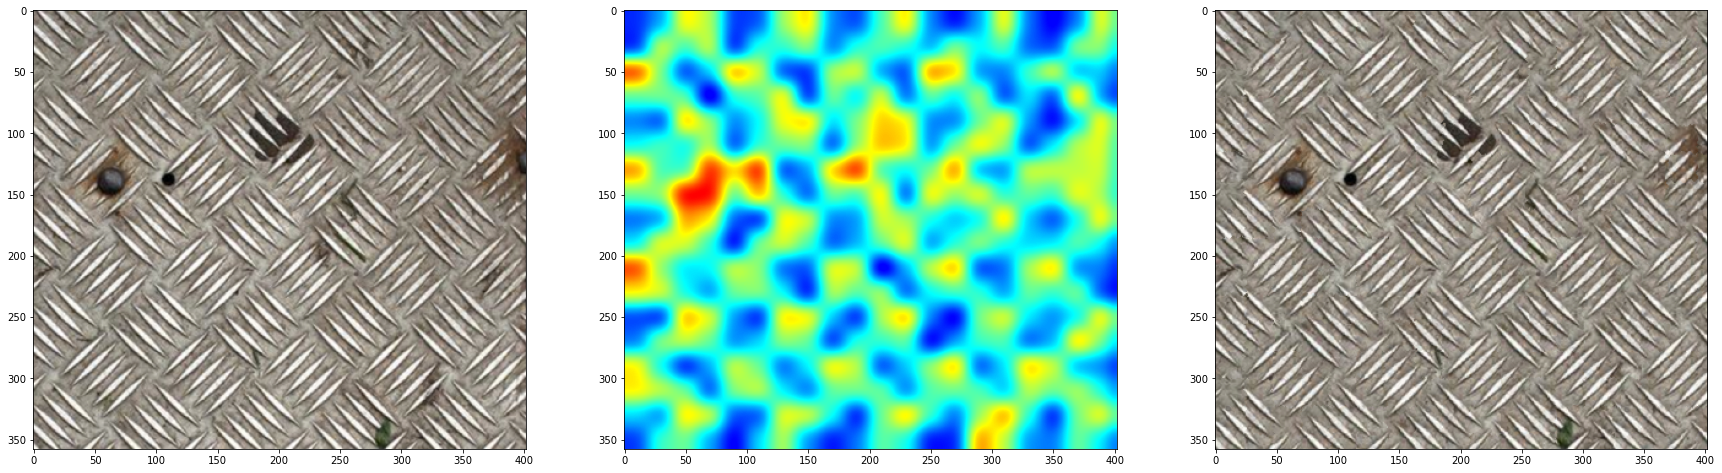

In [55]:
deweathered = deweather('input.png', 0.98, size=(30, 10))

In [56]:
# def generate_deweathering_gif(input_image_name, nframes=30):
    
#     import matplotlib.animation as anim
    
#     if type(input_image_name) != type('str'):
#         print("Please provide the FileName")
#         return
    
#     img = cv2.imread('../images/'+input_image_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     details, gradient = decouple(img)
    
#     age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))
#     age_map = cv2.GaussianBlur(age_map,(41, 41),0)
#     age_map = scale(age_map, 1)
    
#     int_tex, bsize = intact_texture(img, ret_bsize=True)
    
#     timespace = np.linspace(0, 1, nframes)
#     images = np.array([None for i in timespace])
    
#     images[0] = deweather(img, timespace[0], details=details, gradient=gradient, int_tex=int_tex, bsize=bsize, age_map=age_map, t_old=None, size=None)
#     for i in range(1, len(timespace)):
#         print("Frame ", i+1, ".....")
#         images[i] = deweather(img, timespace[i], details=details, gradient=gradient, int_tex=int_tex, bsize=bsize, age_map=age_map, t_old=images[i-1], size=None)

#     return images

# def gen_gif(input_image_name, images=None, nFrames=30):
#     if images is None:
#         images = generate_deweathering_gif(input_image_name, nframes)

#     fig = plt.figure()

#     frames = []
#     for i in images:
#         frames.append([plt.imshow(i, animated=True)])
#     nframes = len(images)
#     gif = anim.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=100)

#     gif.save('../images/'+'deweathering_gif_'+input_image_name+'.gif')
#     print("GIF generated")
#     fig.clear()
    
#     return
    

In [57]:
# images_input = generate_deweathering_gif('input.png')
# # images_texture8 = generate_deweathering_gif('texture8.png')
# gen_gif('input.png', images_input)
# gen_gif('texture8.png', images_texture8)

# Weathering